In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms
import torch.optim as optim
from PIL import Image, ImageEnhance
from image_tasks import *
import cv2
import random
import json
import os

In [2]:
def hist_eq(img_out) :
    img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
    img_out[:, :, 1] = cv2.equalizeHist(img_out[:, :, 1])
    img_out[:, :, 2] = cv2.equalizeHist(img_out[:, :, 2])
    return img_out

In [3]:
def euclidean_distance(vec1, vec2):
    # dim=None flattens the vector to find the euclidean distance
    return torch.linalg.vector_norm(vec1 - vec2, ord=2, dim=None)

In [4]:
class CenterCrop224(object):
    
    def __init__(self, output_size=224):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image):
        img = np.array(image)
        h, w = img.shape[:2]
        sz = self.output_size
        
        if h == w: 
            return cv2.resize(img, (sz, sz), cv2.INTER_AREA)
        
        elif h > w:
            scaling_factor = sz / w
            x_shape = sz
            y_shape = int(h * scaling_factor)
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((y_shape - sz) / 2)
            img_reshaped = img_reshaped[offset:offset + sz, :, :]
            
        else :
            scaling_factor = sz / h
            x_shape = int(w * scaling_factor) 
            y_shape = sz
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((x_shape - sz) / 2)
            img_reshaped = img_reshaped[:, offset:offset+sz, :]
        return img_reshaped
cc224 = CenterCrop224()

In [5]:
transform = transforms.Compose([CenterCrop224(), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])

# transform = transforms.Compose([VGG16_Weights.IMAGENET1K_V1.transforms])
# transform = VGG16_Weights.IMAGENET1K_V1.transforms

### Conv Network

In [6]:
class ConvVgg16(nn.Module):
    def __init__(self, save_switches=False):
        super().__init__()
        
        self.save_switches = save_switches
        # indices of Conv2d layres
        self.modules_no = []
        
        # self.features = vgg16(pretrained=True).features
        self.features = vgg16(weights='DEFAULT').features
        
        for i, feature in enumerate(self.features) :
            if isinstance(feature, nn.MaxPool2d):
                self.features[i] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices = True)
            
            elif isinstance(feature, nn.Conv2d):
                self.modules_no.append(i)
            
        # self.avgpool = vgg16(pretrained=True).avgpool
        self.avgpool = vgg16(weights='DEFAULT').avgpool
        
        # self.classifier = vgg16(pretrained=True).classifier
        self.classifier = vgg16(weights='DEFAULT').classifier
                        
        
    def forward (self, x) :
        conv_results = {}
        maxpool_indices = {}
        for i, layer in enumerate(self.features):
            
            if isinstance(layer, nn.MaxPool2d):
                x, index = layer(x)
                maxpool_indices[i] = index
                
            else :
                x = layer(x)
            
            if isinstance(layer, nn.Conv2d):
                conv_results[i] = x
            
        
            
        x = self.avgpool(x)
        x = x.flatten()
        x = self.classifier(x)
        
        
        if not self.save_switches :
            return x    
            
        return x, conv_results, maxpool_indices
    

### Deconv

In [7]:
class ConvDeconvVGG16(nn.Module) :
    def __init__(self) :
        
        super().__init__()
        
        
        self.conv_model = ConvVgg16(save_switches=True)

        
        self.conv_indices = []
        self.maxpool_indices = []
        
        module_list = []
        
        for i, layer in enumerate(self.conv_model.features) :
            if isinstance(layer, nn.Conv2d):
                module_list.append(nn.ConvTranspose2d(layer.out_channels, layer.in_channels, layer.kernel_size, stride=layer.stride, padding=layer.padding))
                module_list[i].weight.data = layer.weight.data
                self.conv_indices.append(i)
                
            elif isinstance(layer, nn.MaxPool2d):
                module_list.append(nn.MaxUnpool2d(kernel_size=2, stride=2))
                self.maxpool_indices.append(i)
                
            elif isinstance(layer, nn.ReLU):
                module_list.append(nn.ReLU(inplace=True))
        
        module_list.reverse()
        self.module_list = nn.ModuleList(module_list)
     
    
    def __zero_activation(self, y, k) :
        if k == 'channel' :
            y_sum = y.sum(axis=1).sum(axis=1)
            y_argmax = y_sum.argmax().item()
            y_zerod = torch.zeros_like(y)
            y_zerod[y_argmax, :, :] = y[y_argmax, :, :]
            return y_zerod
        
        elif k == 'pixel' :
            y_idx = y.argmax().item()
            y_max = y.max().item()
            y_zerod = torch.zeros_like(y).flatten()
            y_zerod[y_idx] = y_max
            return y_zerod.reshape(y.shape)
    
        
    def forward(self, x, layer_ix, zero_type='channel') :
        
        conv_pred_vector, conv_results, switches  = self.conv_model(x)
        conv_pred = conv_pred_vector.argmax().item()
        
        y = conv_results[self.conv_indices[layer_ix]]
        y = self.__zero_activation(y, zero_type)

        
        
        for i, layer in enumerate(self.module_list[(30 - self.conv_indices[layer_ix]):]) :
            if isinstance(layer, nn.MaxUnpool2d):
                y = layer(y, switches[self.conv_indices[layer_ix] - i])
            else :
                y = layer(y)
                
        ret = {"pred_prob" : conv_pred_vector, "pred" : conv_pred, "conv_results": conv_results, "deconv" : y}
        return ret
        
        

In [8]:
model = ConvDeconvVGG16()

## Random Images from Dataset 

In [9]:
json_data = json.load(open('../Training/imagenet_class_index.json', 'r'))

In [16]:
image_dir = "../images/test"

def get_random_images(x=3):
    """Gets x images from the test set"""
    image_classes = np.random.choice(1000, x)
    image_class_names = [ json_data[str(i)][1] for i in image_classes]
    image_names = [ json_data[str(i)][0] + "_" + json_data[str(i)][1] + ".JPEG" for i in image_classes]
    image_files = [os.path.join(image_dir, image_name) for image_name in image_names]
    images = [open_image(image_file) for image_file in image_files]
    
    return image_classes, image_class_names, images

## Vertical Translation

In [17]:
def plot_sample_images(func, func_title, y):
    _, _, img = get_random_images()
    img = resize_image(img[0], 224)

    fig, ax = plt.subplots(1, y.size, figsize=(20, 7))

    for i, val in enumerate(y):
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        translated_img = func(img, val)
        ax[i].imshow(translated_img)
        ax[i].set_title("%s: %.2f" % (func_title, val))
        ax[i].axis('off')

    fig.suptitle(f"Sample {func_title}")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

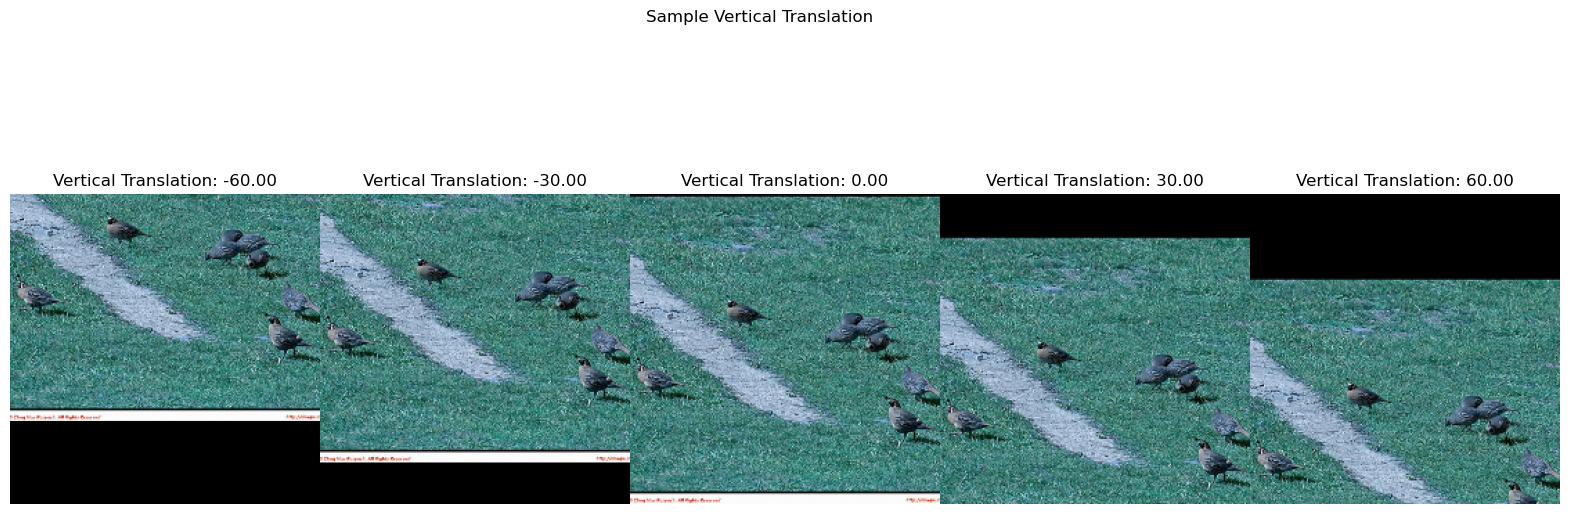

In [18]:
plot_sample_images(vert_trans_image, "Vertical Translation", np.arange(-60, 61, 30))

In [19]:
def compute_distances(img, y, func, layer_index=5):
    
    distances = np.zeros(y.shape)

    untransformed_feature_vector = model(transform(img), layer_index)['deconv']

    for i, val in enumerate(y):
        changed_img = func(img, val)
        feature_vector = model(transform(changed_img), layer_index)['deconv']

        distances[i] = euclidean_distance(untransformed_feature_vector, feature_vector)
    
    return distances

In [20]:
def compute_probability(img, y, func, image_class):
    
    probabilities = np.zeros(y.shape)

    for i, val in enumerate(y):
        changed_img = func(img, val)
        probabilities[i] = model(transform(changed_img), 7)['pred_prob'][image_class]
    return probabilities

In [25]:
def plot_prob(image_classes, image_names, images, func, func_title, y):
    
    for j, img in enumerate(images):
        probability = compute_probability(img, y, func, image_classes[j])

        plt.xlabel(f"{func_title}")
        plt.ylabel("True Probability")
        plt.plot(y, probability, label=f"{image_names[j]}")
    
    plt.legend()
    plt.title(f"{func_title}")
    plt.show()

def plot_distances(func, func_title, y):
    image_class, image_name, images = get_random_images()

    plot_prob(image_class, image_name, images, func, func_title, y)

    for i in [0, 5]:
        for j, img in enumerate(images):
            distances = compute_distances(img, y, func, i)

            plt.xlabel(f"{func_title}")
            plt.ylabel("Canonical Distance")
            plt.plot(y, distances, label=f"{image_name[j]}")
        
        plt.legend()
        plt.title(f"{func_title}: Layer {i+1}")
        plt.show()

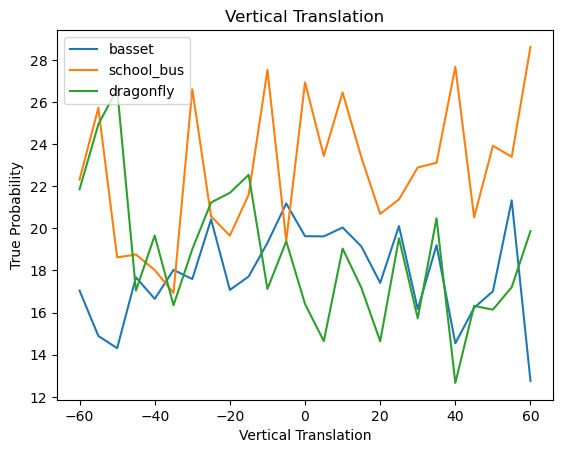

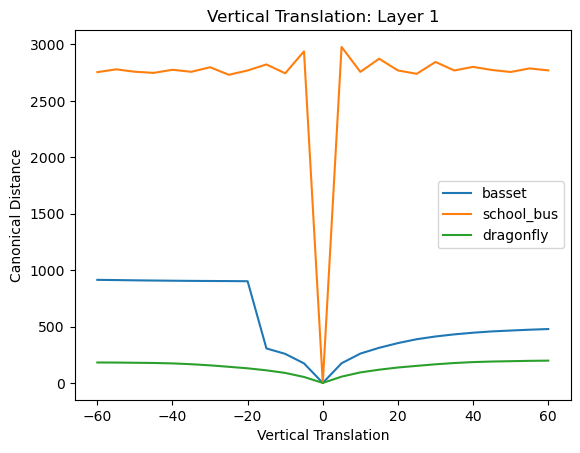

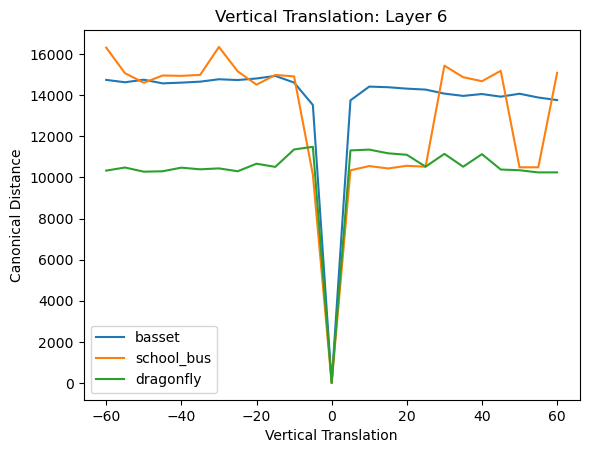

In [26]:
plot_distances(vert_trans_image, "Vertical Translation", y = np.arange(-60, 61, 5))

## Scaling

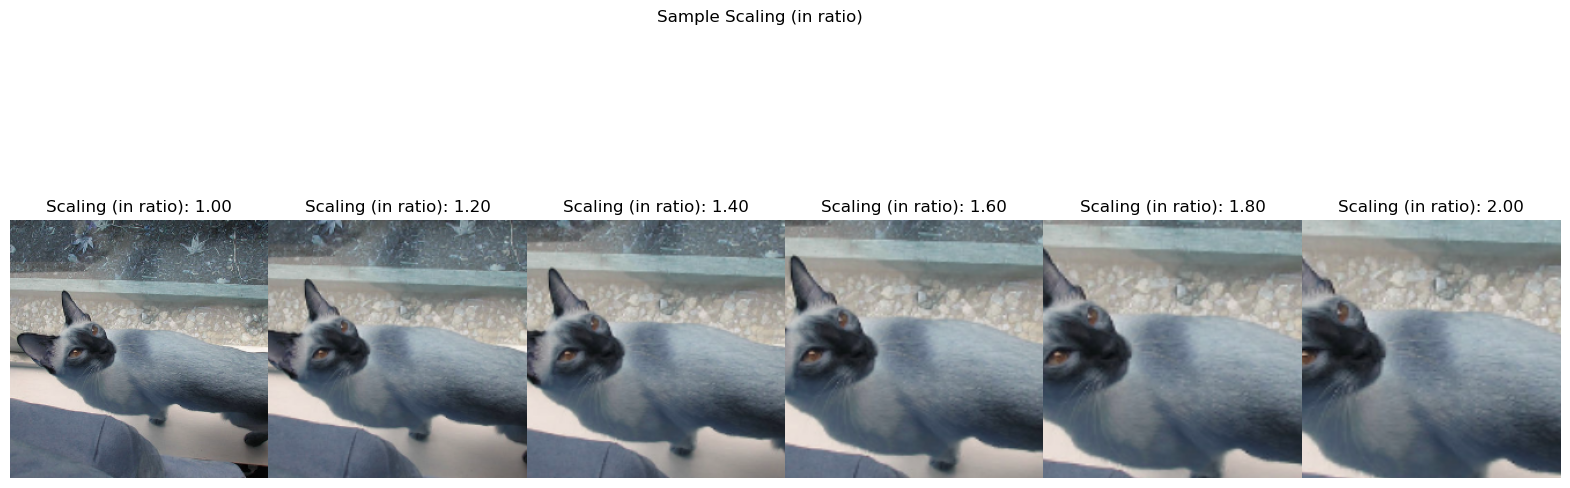

In [29]:
plot_sample_images(scale_image, "Scaling (in ratio)", np.arange(1, 2.01, 0.2))

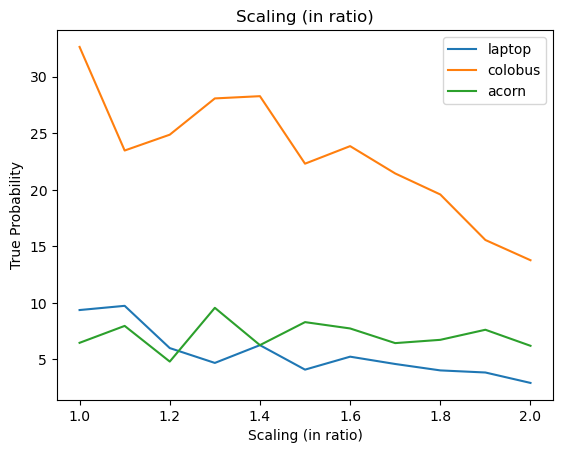

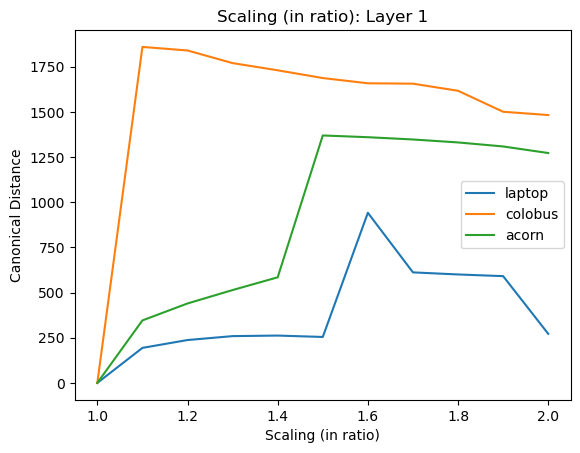

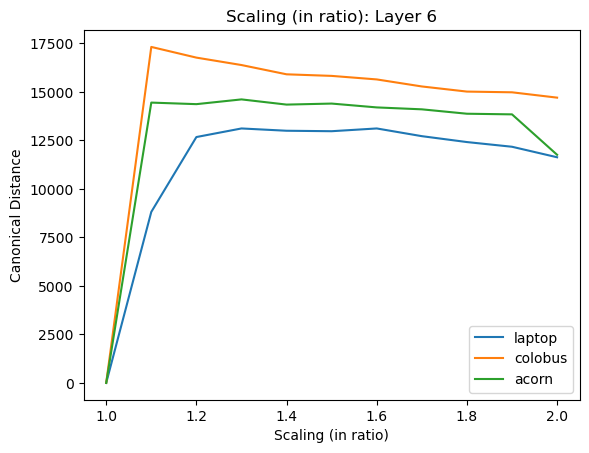

In [33]:
plot_distances(scale_image, "Scaling (in ratio)", np.arange(1, 2.01, 0.1))

## Rotation

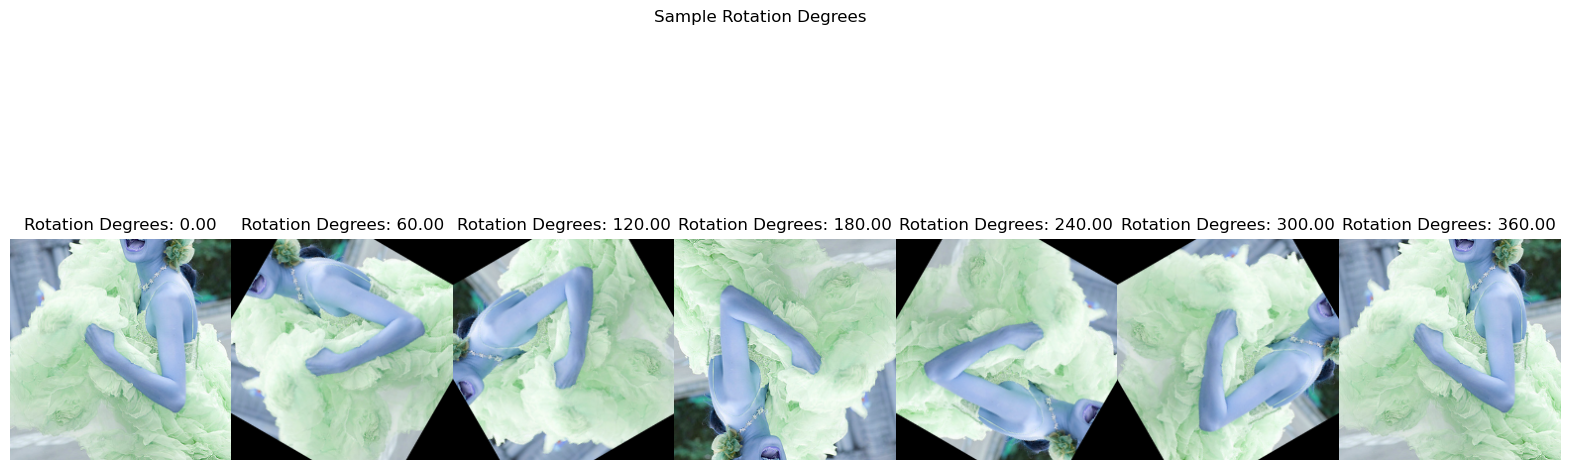

In [32]:
plot_sample_images(rotate_image, "Rotation Degrees", np.arange(0, 361, 60))

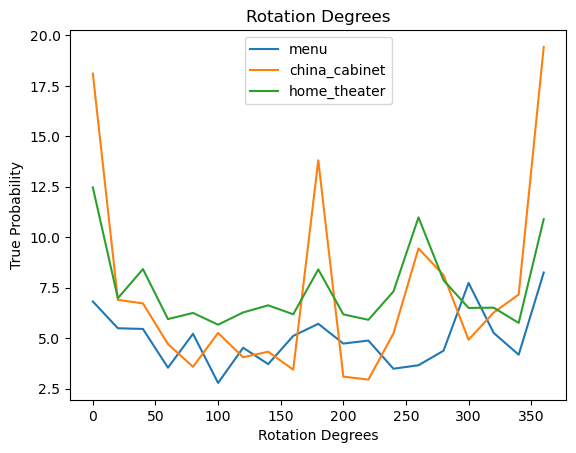

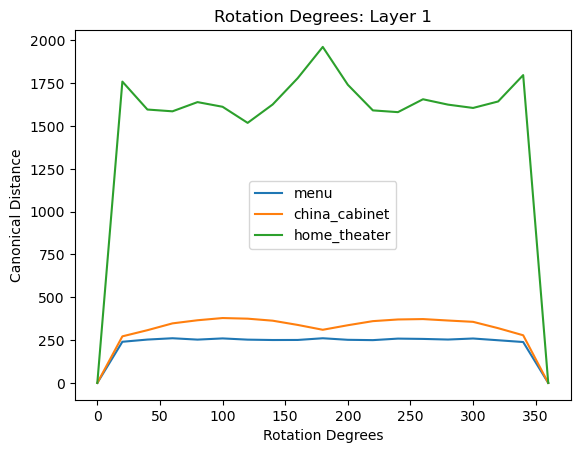

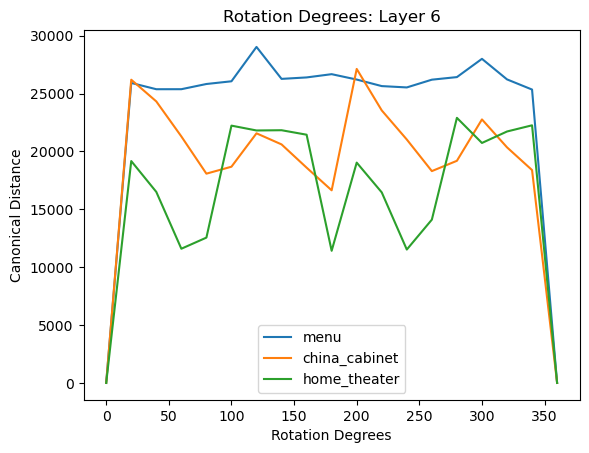

In [31]:
plot_distances(rotate_image, "Rotation Degrees", np.arange(0, 361, 20))